In [1]:
import os
%load_ext autoreload
%autoreload 2
import pandas as pd


import warnings
warnings.filterwarnings('ignore')

from logic.data_processing.data_import import dataload
from logic.data_processing.data_processing import data_proc
from logic.ml.classification_shap import IDEARs_funcs

In [7]:
dp=data_proc()

In [ ]:
%%time
df_dis_date=dp.dis_date_file()

In [18]:

ac=dataload()
df=ac.output_treats(load=1)

In [21]:
icd10=ac.ICD10_out()

In [22]:
icd10

,eid,date_of_attending_assessment_centre_f53_0_0,age_when_attended_assessment_centre_f21003_0_0,date_of_death_f40000_0_0,diagnoses_icd10_f41270_0_0,diagnoses_icd10_f41270_0_1,diagnoses_icd10_f41270_0_2,diagnoses_icd10_f41270_0_3,diagnoses_icd10_f41270_0_4,diagnoses_icd10_f41270_0_5,...,date_of_first_inpatient_diagnosis_icd10_f41280_0_216,date_of_first_inpatient_diagnosis_icd10_f41280_0_217,date_of_first_inpatient_diagnosis_icd10_f41280_0_218,date_of_first_inpatient_diagnosis_icd10_f41280_0_219,date_of_first_inpatient_diagnosis_icd10_f41280_0_220,date_of_first_inpatient_diagnosis_icd10_f41280_0_221,date_of_first_inpatient_diagnosis_icd10_f41280_0_222,date_of_first_inpatient_diagnosis_icd10_f41280_0_223,date_of_first_inpatient_diagnosis_icd10_f41280_0_224,date_of_first_inpatient_diagnosis_icd10_f41280_0_225
0,1000014,2007-07-24,59.0,NaN,I10,K439,Z880,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000023,2007-08-24,41.0,NaN,N328,N393,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000030,2009-07-06,63.0,NaN,C444,K219,K297,M1999,M201,M205,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1000041,2009-01-26,65.0,NaN,E039,K219,K449,K922,Z121,Z800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1000059,2009-11-03,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502443,6025211,2008-07-14,68.0,NaN,G560,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
502444,6025228,2007-11-01,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
502445,6025235,2010-04-27,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
502446,6025244,2007-12-22,41.0,NaN,K011,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
os.listdir('/Users/michaelallwright/Dropbox (Sydney Uni)/michael_PhD/Projects/UKB/Data/')

In [9]:
ac=IDEARs_funcs()
drops=['date_of_attending_assessment_centre_f53_0_0','AD']
wordsremove='inpatient_record|patient_polymorph|time_since_interview|_HES|records_in_hes|treatment_speciality|Diag_PD|Age_Diag_Dementia|Age_Diag_PD|\
Parkinson|interviewer|date_of_attending_assessment_centre_f53|years_after_dis|\
Frontotemporal|daysto|hospital_recoded|from_hospital|Age_Today|year_of_birth|pollution_|pesticide_exposure|\
parental_ad_status_|birth_weight|parkins|sex_inference|\
admission_polymorphic|faster_mot|drive_faster_than|time_to_complete_round|Genotype|genetic_principal|xxxx'

In [7]:
ratio=0.2
agemin=50
agemax=70
df_pd=pd.read_parquet(ac.path+'df_PD_newcols.parquet')#df_pd_20210924
df_pd.rename(columns={'total_dis':'total ICD10 conditions at baseline'},inplace=True)
mask_age=(df_pd['age_when_attended_assessment_centre_f21003_0_0']>=agemin)&(df_pd['age_when_attended_assessment_centre_f21003_0_0']<=agemax)

df_pd=ac.maskapoedf(df_pd[mask_age],apoe=3)

#for v in agenorm_vars:
#    df_pd=ac.agenorm(df_pd,v)

mask=(df_pd['PD']==1)
df_pd_val=pd.concat([df_pd[mask].sample(round(ratio*df_pd[mask].shape[0])),df_pd[~mask].sample(round(ratio*df_pd[~mask].shape[0]))],axis=0)
mask_val=(df_pd['eid'].isin(df_pd_val['eid']))
df_pd=df_pd[~mask_val]

Total PD 1468.0
[18:05:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { enable_categorical } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0
0.005086723296481268
[18:10:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { enable_categorical } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Val SHAP
140562
1
[18:11:14] WARNING: /opt/concourse/worker/volumes

<Figure size 3000x3000 with 0 Axes>

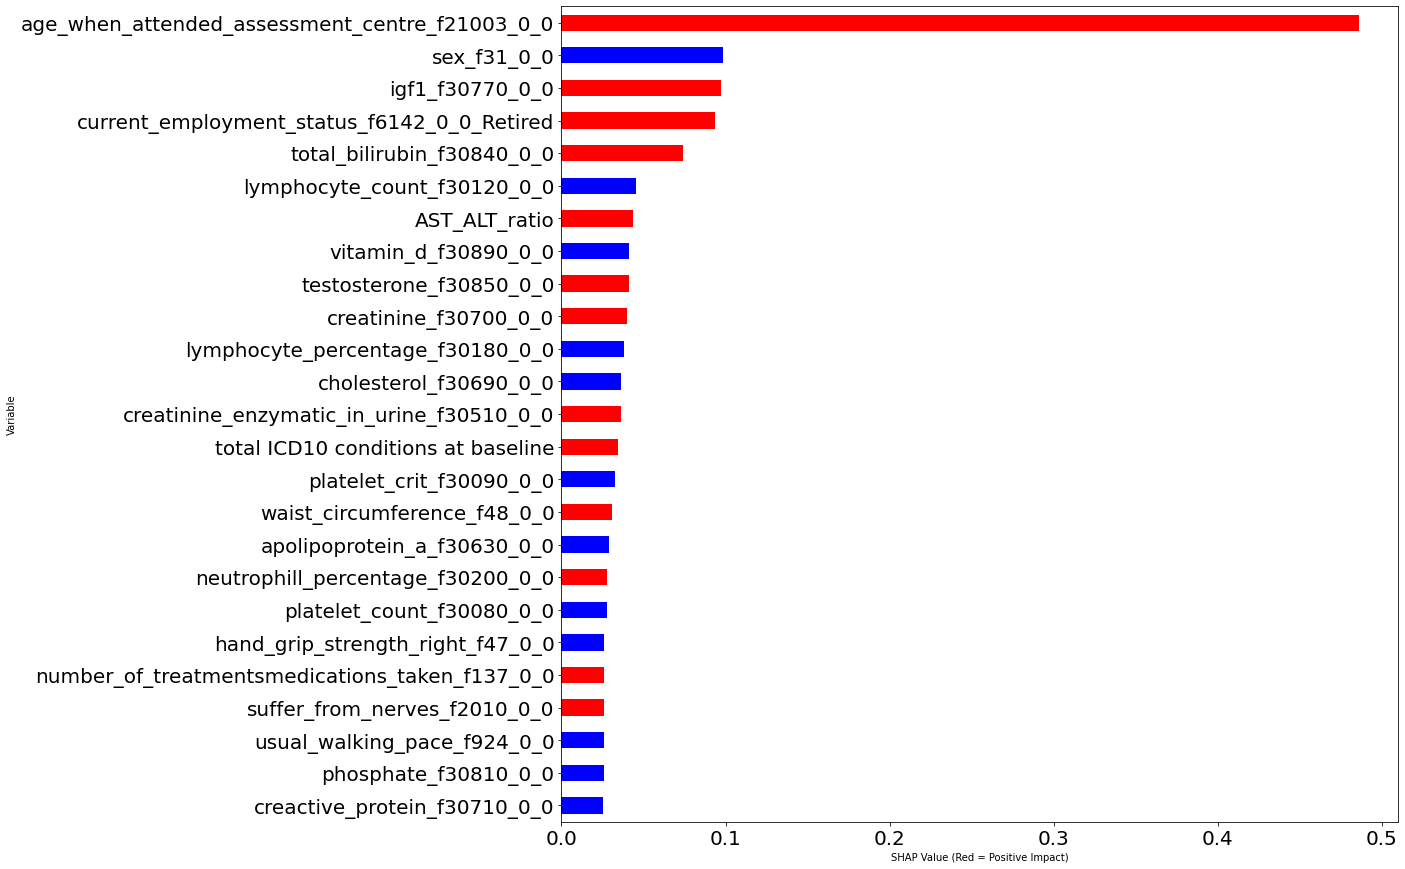

In [10]:
dropsPD=drops+['dementia']
outs_pd=ac.runmodels(df=df_pd,depvar='PD',reps=1,splits=2,drops=dropsPD,wordsremove=wordsremove,model=ac.model(),
             featsfit=30,LRcheck=0,resizeratio=30,agemin=50,agemax=70,verbose=0,apoe=3,tree=1,
             plot_type='dot')

k2=ac.ABS_SHAP(outs_pd[3], outs_pd[4],25,figx=15,figy=15)
